#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

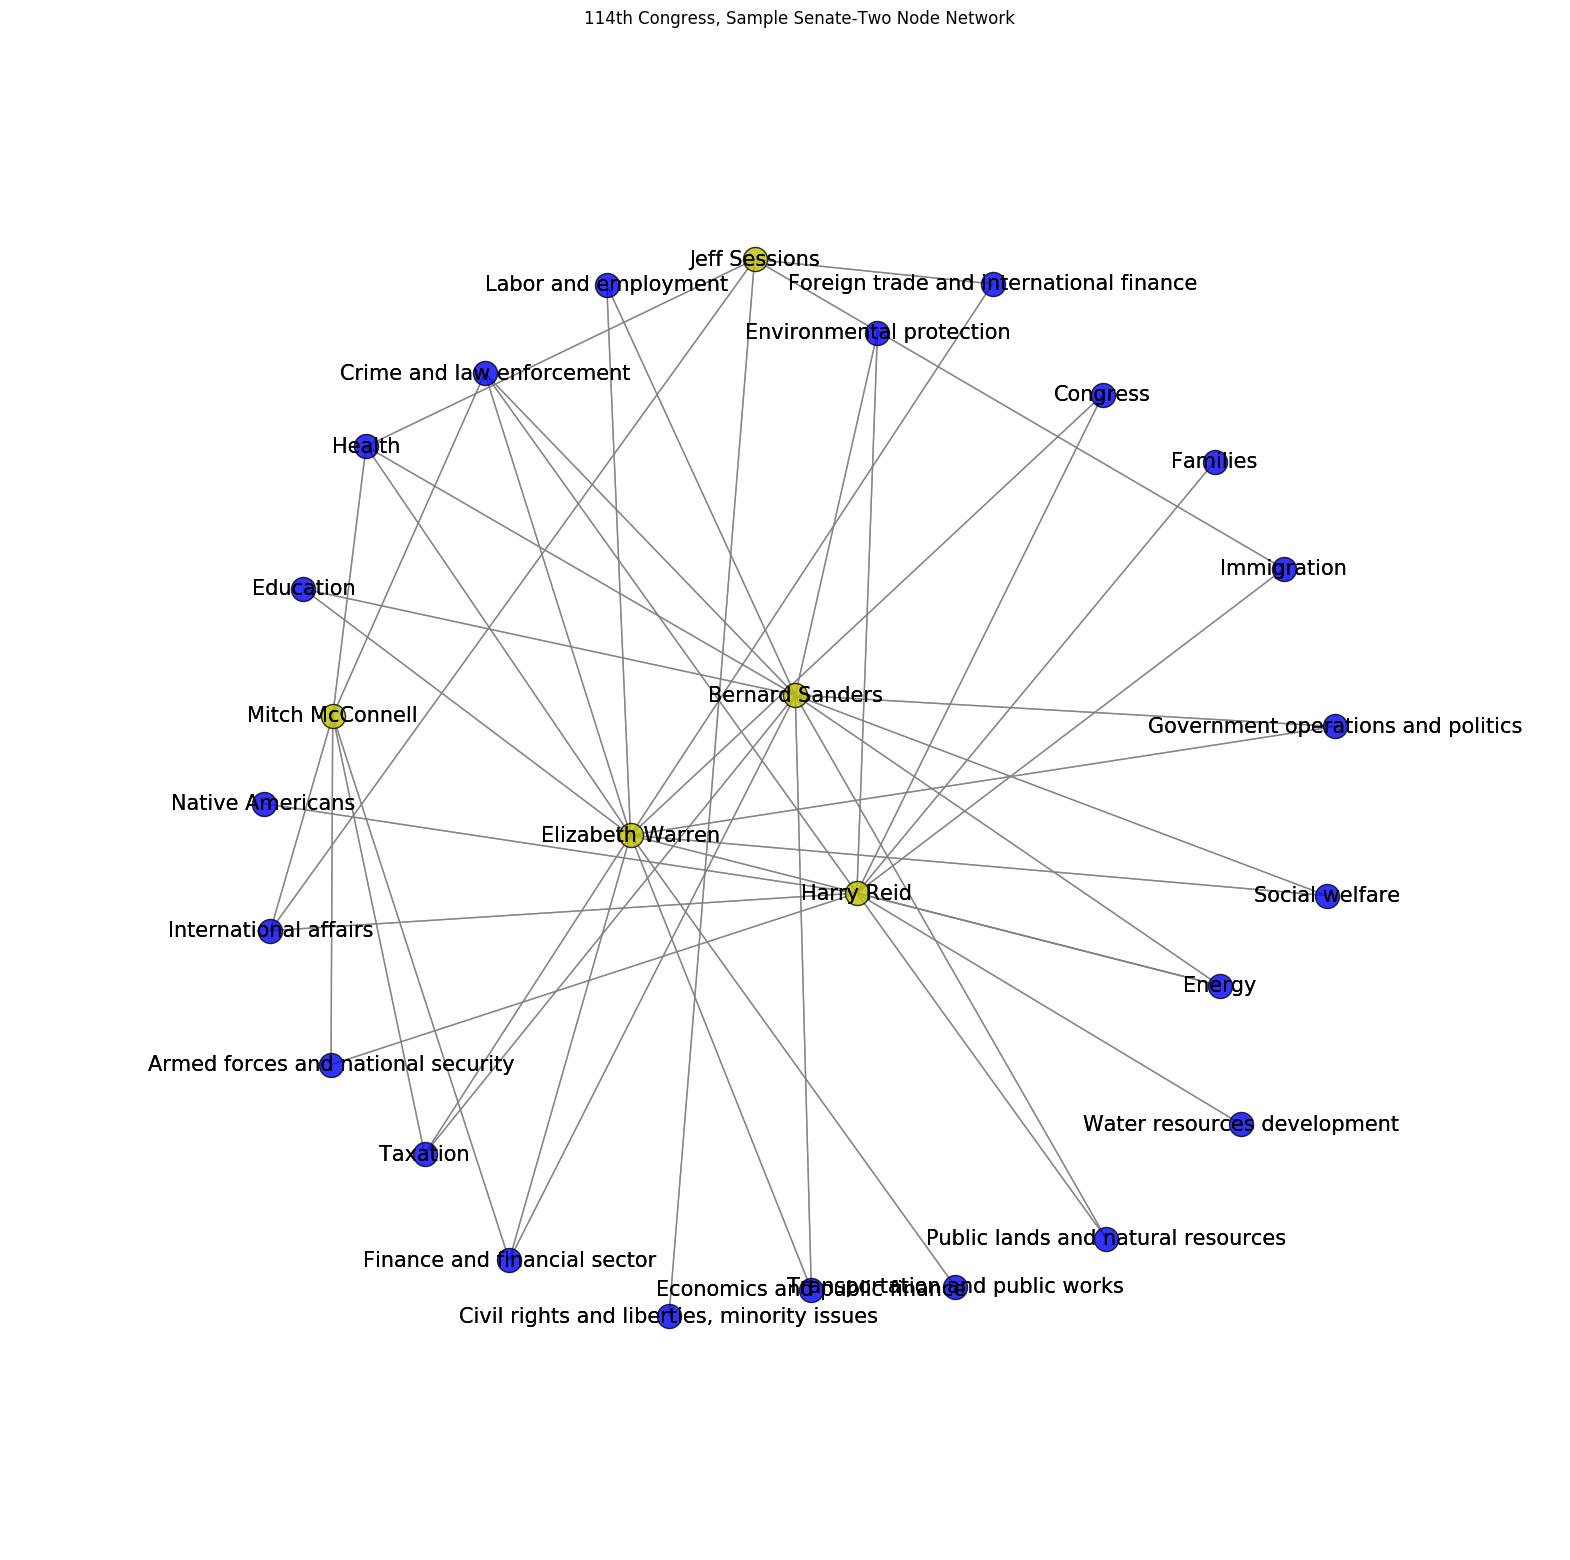

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

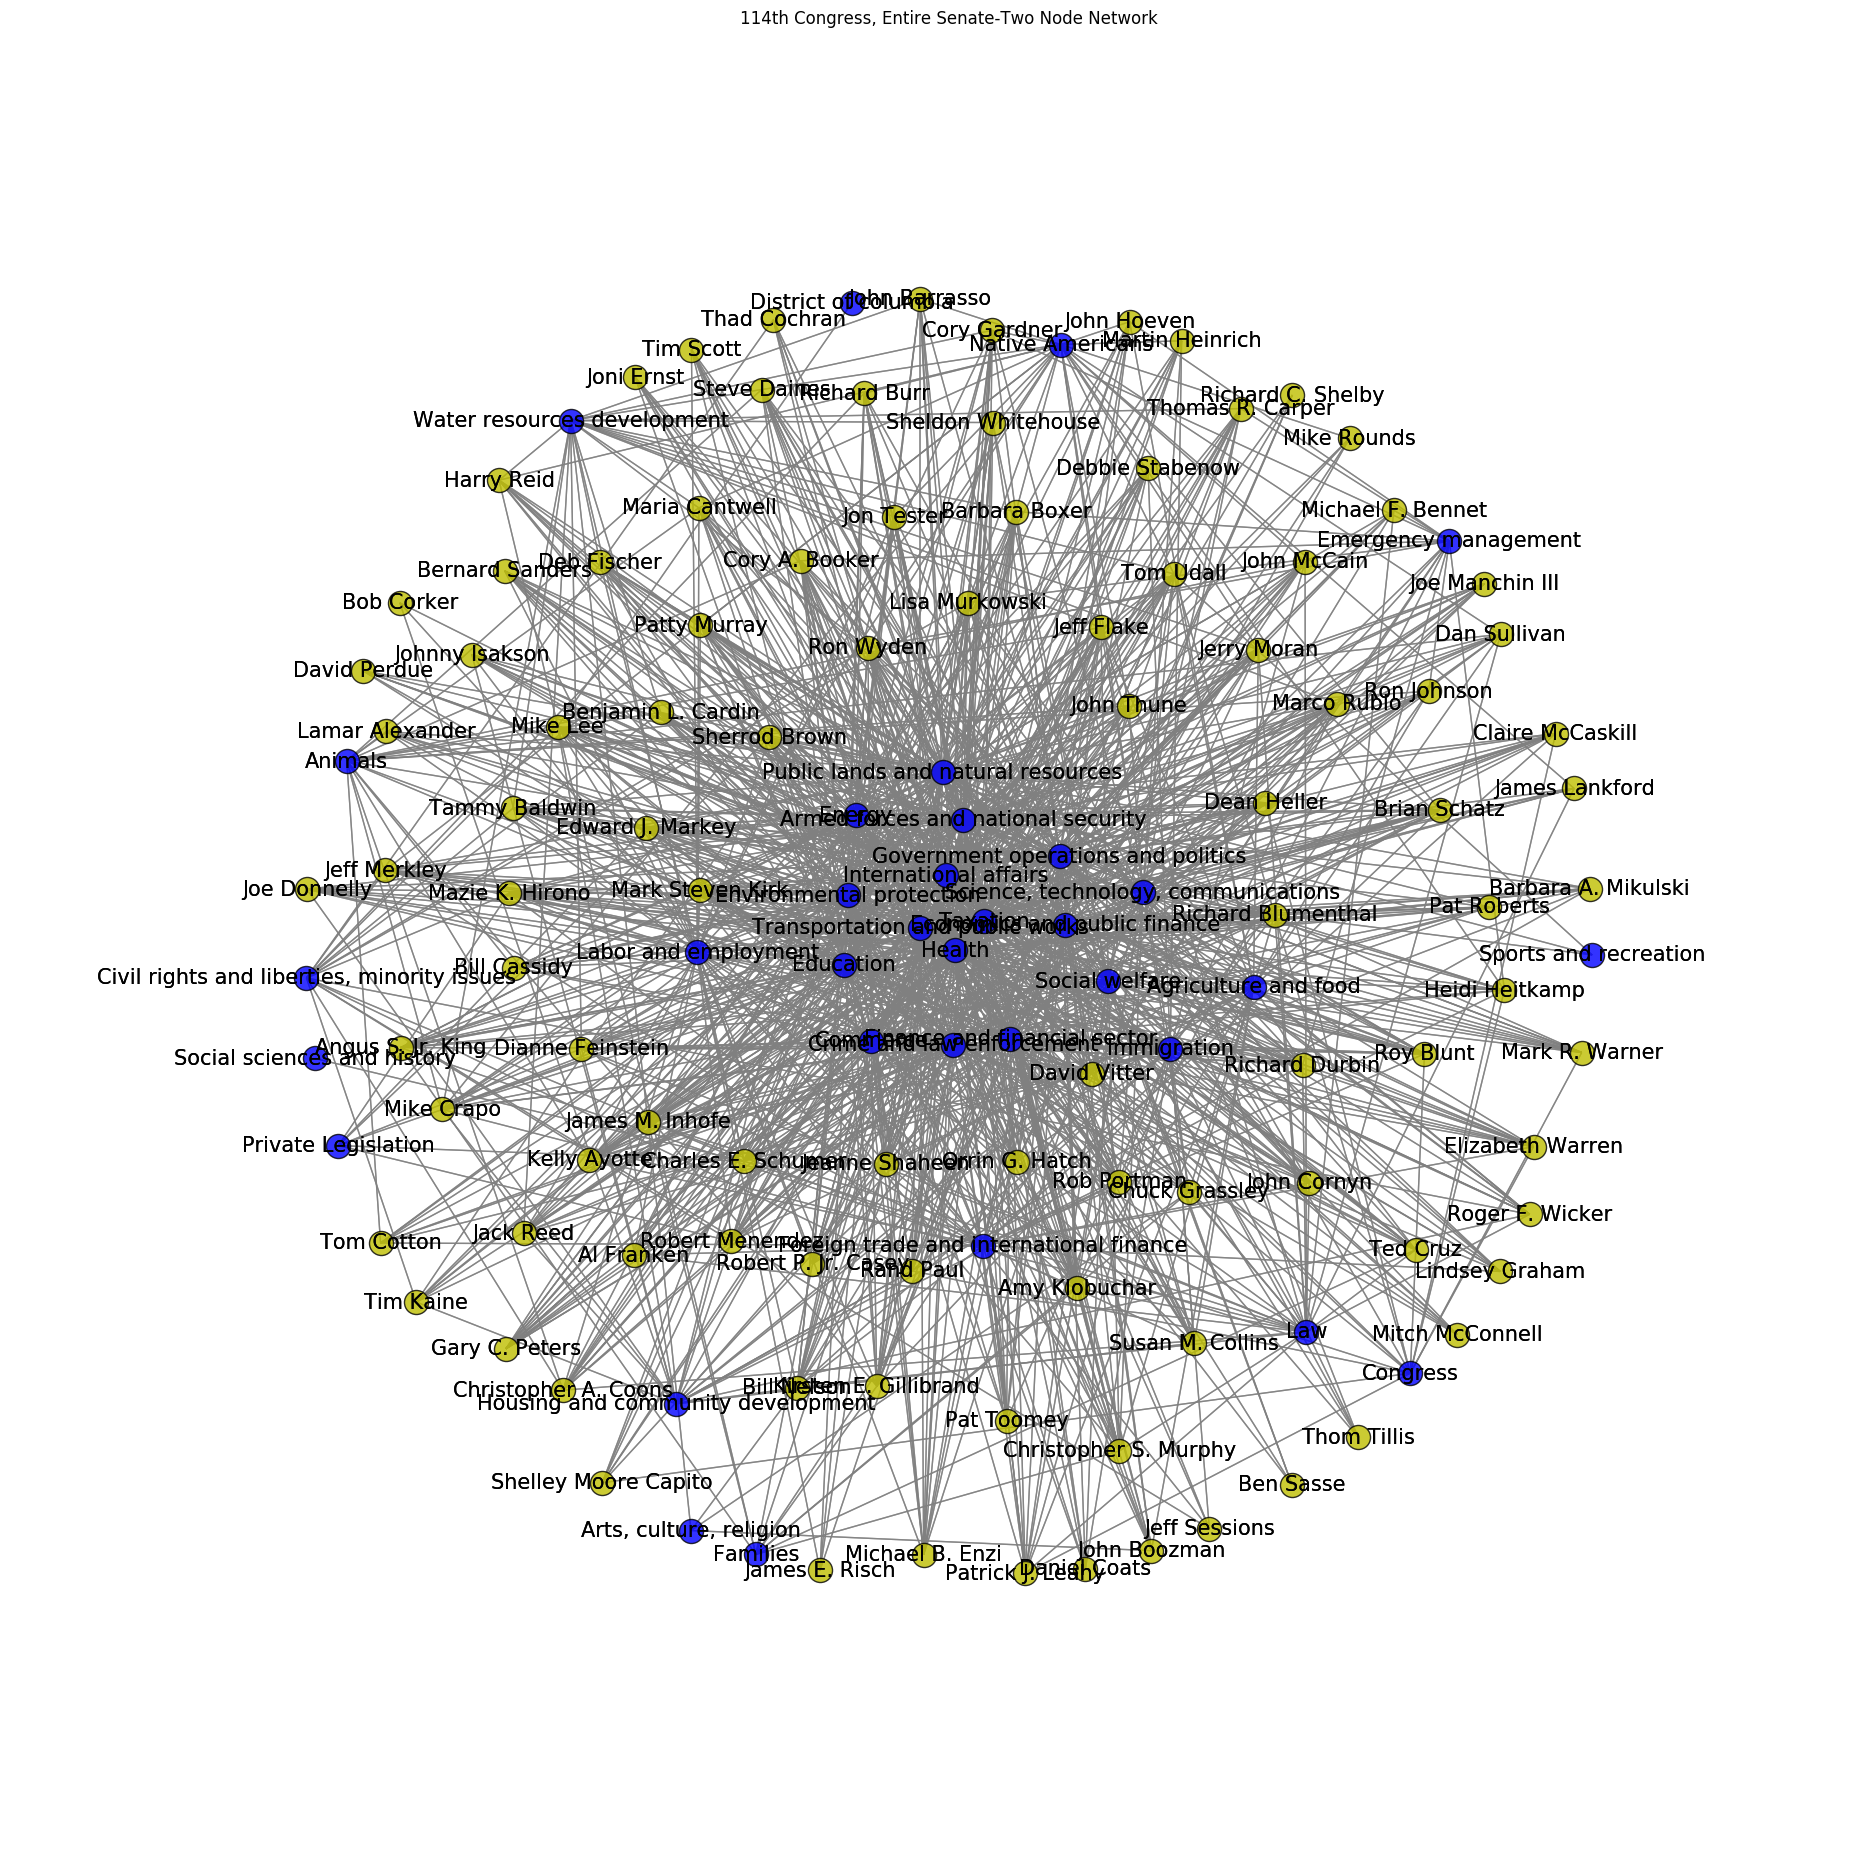

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Subjects'])
df

34


Subjects
0                     Crime and law enforcement
1                          Labor and employment
2                      Environmental protection
3                                       Animals
4                           Private Legislation
5                                           Law
6            Public lands and natural resources
7                   Water resources development
8                                      Commerce
9       Foreign trade and international finance
10  Civil rights and liberties, minority issues
11                  Social sciences and history
12          Science, technology, communications
13                         Emergency management
14                                    Education
15              Transportation and public works
16            Housing and community development
17           Government operations and politics
18           Armed forces and national security
19                               Social welfare
20                 Finance and financial sector
21                                     Congress
22                                       Energy
23                                     Taxation
24                         District of columbia
25                         Agriculture and food
26                                  Immigration
27                        Sports and recreation
28                      Arts, culture, religion
29                                     Families
30                        International affairs
31                 Economics and public finance
32                             Native Americans
33                                       Health

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Senators'])
df

100


Senators
0         Michael B. Enzi
1   Kirsten E. Gillibrand
2               Roy Blunt
3             Jerry Moran
4          James Lankford
5              Joni Ernst
6    Shelley Moore Capito
7               Rand Paul
8             Rob Portman
9          Lindsey Graham
10              Ron Wyden
11           Richard Burr
12          Barbara Boxer
13            Marco Rubio
14          Tammy Baldwin
15       Edward J. Markey
16         Lisa Murkowski
17           Bill Cassidy
18           Cory Gardner
19     Sheldon Whitehouse
20            John McCain
21      Michael F. Bennet
22        Debbie Stabenow
23        James M. Inhofe
24              Tom Udall
25             Pat Toomey
26             Jon Tester
27            Thom Tillis
28       Susan M. Collins
29          Jeff Sessions
..                    ...
70         Heidi Heitkamp
71        Robert Menendez
72        Joe Manchin III
73             Al Franken
74             Harry Reid
75         Gary C. Peters
76    Robert P. Jr. Casey
77          John Barrasso
78        Roger F. Wicker
79          Amy Klobuchar
80       Thomas R. Carper
81             Bob Corker
82           John Boozman
83        Martin Heinrich
84         Orrin G. Hatch
85         Chuck Grassley
86     Richard Blumenthal
87            Deb Fischer
88     Charles E. Schumer
89           Thad Cochran
90           Dan Sullivan
91            John Hoeven
92         James E. Risch
93       Dianne Feinstein
94              Jack Reed
95            Dean Heller
96           Steve Daines
97      Angus S. Jr. King
98         Johnny Isakson
99         Maria Cantwell

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
130                                   Al Franken          0
132                                Amy Klobuchar          0
120                            Angus S. Jr. King          0
25                           Barbara A. Mikulski          0
39                                 Barbara Boxer          0
84                                     Ben Sasse          0
97                            Benjamin L. Cardin          0
80                               Bernard Sanders          0
48                                  Bill Cassidy          0
50                                   Bill Nelson          0
124                                   Bob Corker          0
14                                  Brian Schatz          0
104                           Charles E. Schumer          0
102                         Christopher A. Coons          0
122                        Christopher S. Murphy          0
126                               Chuck Grassley          0
37                              Claire McCaskill          0
78                                Cory A. Booker          0
49                                  Cory Gardner          0
107                                 Dan Sullivan          0
34                                  Daniel Coats          0
44                                  David Perdue          0
123                                 David Vitter          0
117                                  Dean Heller          0
103                                  Deb Fischer          0
64                               Debbie Stabenow          0
114                             Dianne Feinstein          0
45                              Edward J. Markey          0
23                              Elizabeth Warren          0
70                                Gary C. Peters          0
..                                           ...        ...
17   Civil rights and liberties, minority issues          1
85                                      Commerce          1
112                                     Congress          1
10                     Crime and law enforcement          1
13                          District of columbia          1
67                  Economics and public finance          1
26                                     Education          1
109                         Emergency management          1
51                                        Energy          1
35                      Environmental protection          1
52                                      Families          1
106                 Finance and financial sector          1
89       Foreign trade and international finance          1
59            Government operations and politics          1
131                                       Health          1
32             Housing and community development          1
54                                   Immigration          1
62                         International affairs          1
4                           Labor and employment          1
11                                           Law          1
63                              Native Americans          1
71                           Private Legislation          1
12            Public lands and natural resources          1
91           Science, technology, communications          1
21                   Social sciences and history          1
43                                Social welfare          1
6                          Sports and recreation          1
116                                     Taxation          1
28               Transportation and public works          1
88                   Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Senator', 'Subject', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Subject'], ascending = True, inplace=True)
ShortPath

Senator                Subject  ShortestPath
798          Agriculture and food          Amy Klobuchar             1
787          Agriculture and food      Angus S. Jr. King             1
789          Agriculture and food  Christopher S. Murphy             1
793          Agriculture and food         Chuck Grassley             1
777          Agriculture and food           Dan Sullivan             1
729          Agriculture and food           David Perdue             1
790          Agriculture and food           David Vitter             1
744          Agriculture and food        James M. Inhofe             1
766          Agriculture and food         Jeanne Shaheen             1
761          Agriculture and food             Jeff Flake             1
710          Agriculture and food            Jerry Moran             1
763          Agriculture and food           John Boozman             1
779          Agriculture and food            John Hoeven             1
702          Agriculture and food  Kirsten E. Gillibrand             1
731          Agriculture and food         Lisa Murkowski             1
709          Agriculture and food               Mike Lee             1
755          Agriculture and food            Pat Roberts             1
778          Agriculture and food       Patrick J. Leahy             1
712          Agriculture and food           Patty Murray             1
772          Agriculture and food     Richard Blumenthal             1
715          Agriculture and food         Richard Durbin             1
737          Agriculture and food        Robert Menendez             1
748          Agriculture and food    Robert P. Jr. Casey             1
751          Agriculture and food        Roger F. Wicker             1
717          Agriculture and food            Ron Johnson             1
752          Agriculture and food       Susan M. Collins             1
764          Agriculture and food              Tom Udall             1
2468                      Animals     Benjamin L. Cardin             1
2433                      Animals           Bill Cassidy             1
2473                      Animals   Christopher A. Coons             1
...                           ...                    ...           ...
2601  Water resources development        Michael B. Enzi             3
2641  Water resources development      Michael F. Bennet             3
2609  Water resources development               Mike Lee             3
2632  Water resources development            Mike Rounds             3
2657  Water resources development        Mitch McConnell             3
2665  Water resources development         Orrin G. Hatch             3
2655  Water resources development            Pat Roberts             3
2645  Water resources development             Pat Toomey             3
2678  Water resources development       Patrick J. Leahy             3
2612  Water resources development           Patty Murray             3
2619  Water resources development              Rand Paul             3
2672  Water resources development     Richard Blumenthal             3
2625  Water resources development           Richard Burr             3
2662  Water resources development      Richard C. Shelby             3
2615  Water resources development         Richard Durbin             3
2620  Water resources development            Rob Portman             3
2637  Water resources development        Robert Menendez             3
2648  Water resources development    Robert P. Jr. Casey             3
2651  Water resources development        Roger F. Wicker             3
2617  Water resources development            Ron Johnson             3
2643  Water resources development              Roy Blunt             3
2618  Water resources development   Shelley Moore Capito             3
2660  Water resources development          Sherrod Brown             3
2652  Water resources development       Susan M. Collins             3
2603  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
131                                       Health   0.692708     0.101990   
118                                     Taxation   0.651961     0.081904   
12            Public lands and natural resources   0.604545     0.064795   
103           Government operations and politics   0.599099     0.063533   
42            Armed forces and national security   0.588496     0.064645   
3                      Crime and law enforcement   0.545082     0.045923   
28               Transportation and public works   0.545082     0.042655   
26                                     Education   0.527778     0.035685   
127                                 David Vitter   0.523622     0.008982   
126                        International affairs   0.519531     0.046628   
107                 Finance and financial sector   0.515504     0.036473   
106                     Environmental protection   0.515504     0.033388   
132                                Amy Klobuchar   0.515504     0.006491   
72                                    Jeff Flake   0.511538     0.006419   
96                                Jeanne Shaheen   0.507634     0.006398   
95                                Orrin G. Hatch   0.507634     0.005318   
105                           Charles E. Schumer   0.503788     0.021357   
80                                      Mike Lee   0.503788     0.019391   
68                                     Tom Udall   0.503788     0.009767   
102                           Richard Blumenthal   0.503788     0.009606   
55                               Robert Menendez   0.503788     0.006964   
33                                     Ron Wyden   0.503788     0.005168   
120                               Richard Durbin   0.503788     0.004653   
31                                   Rob Portman   0.503788     0.004406   
130                             Mark Steven Kirk   0.503788     0.004089   
67                               James M. Inhofe   0.500000     0.008501   
50                                   Bill Nelson   0.500000     0.007933   
8                                     Mike Crapo   0.500000     0.006094   
116                             Dianne Feinstein   0.500000     0.005646   
40                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
6                                Lamar Alexander   0.458621     0.000788   
29                          Shelley Moore Capito   0.458621     0.000670   
77                                  Thad Cochran   0.458621     0.000557   
83                               Mitch McConnell   0.458621     0.000255   
79                                 Jeff Sessions   0.449324     0.000474   
86                                     Ben Sasse   0.449324     0.000134   
125                 Economics and public finance   0.446309     0.015759   
35                                   Mike Rounds   0.446309     0.000284   
92                             Richard C. Shelby   0.446309     0.000151   
54                                   Immigration   0.443333     0.015822   
43                                Social welfare   0.443333     0.014690   
91       Foreign trade and international finance   0.437500     0.015152   
74                                   Thom Tillis   0.437500     0.000262   
115                               James E. Risch   0.437500     0.000176   
19                          Agriculture and food   0.423567     0.008114   
63                              Native Americans   0.420886     0.008903   
47                                           Law   0.418239     0.006880   
32             Housing and community development   0.413043     0.007747   
90                   Water resources development   0.407975     0.004550   
84                                       Animals   0.398204     0.003565   
114                                     Congress   0.393491     0.002552   
17   Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

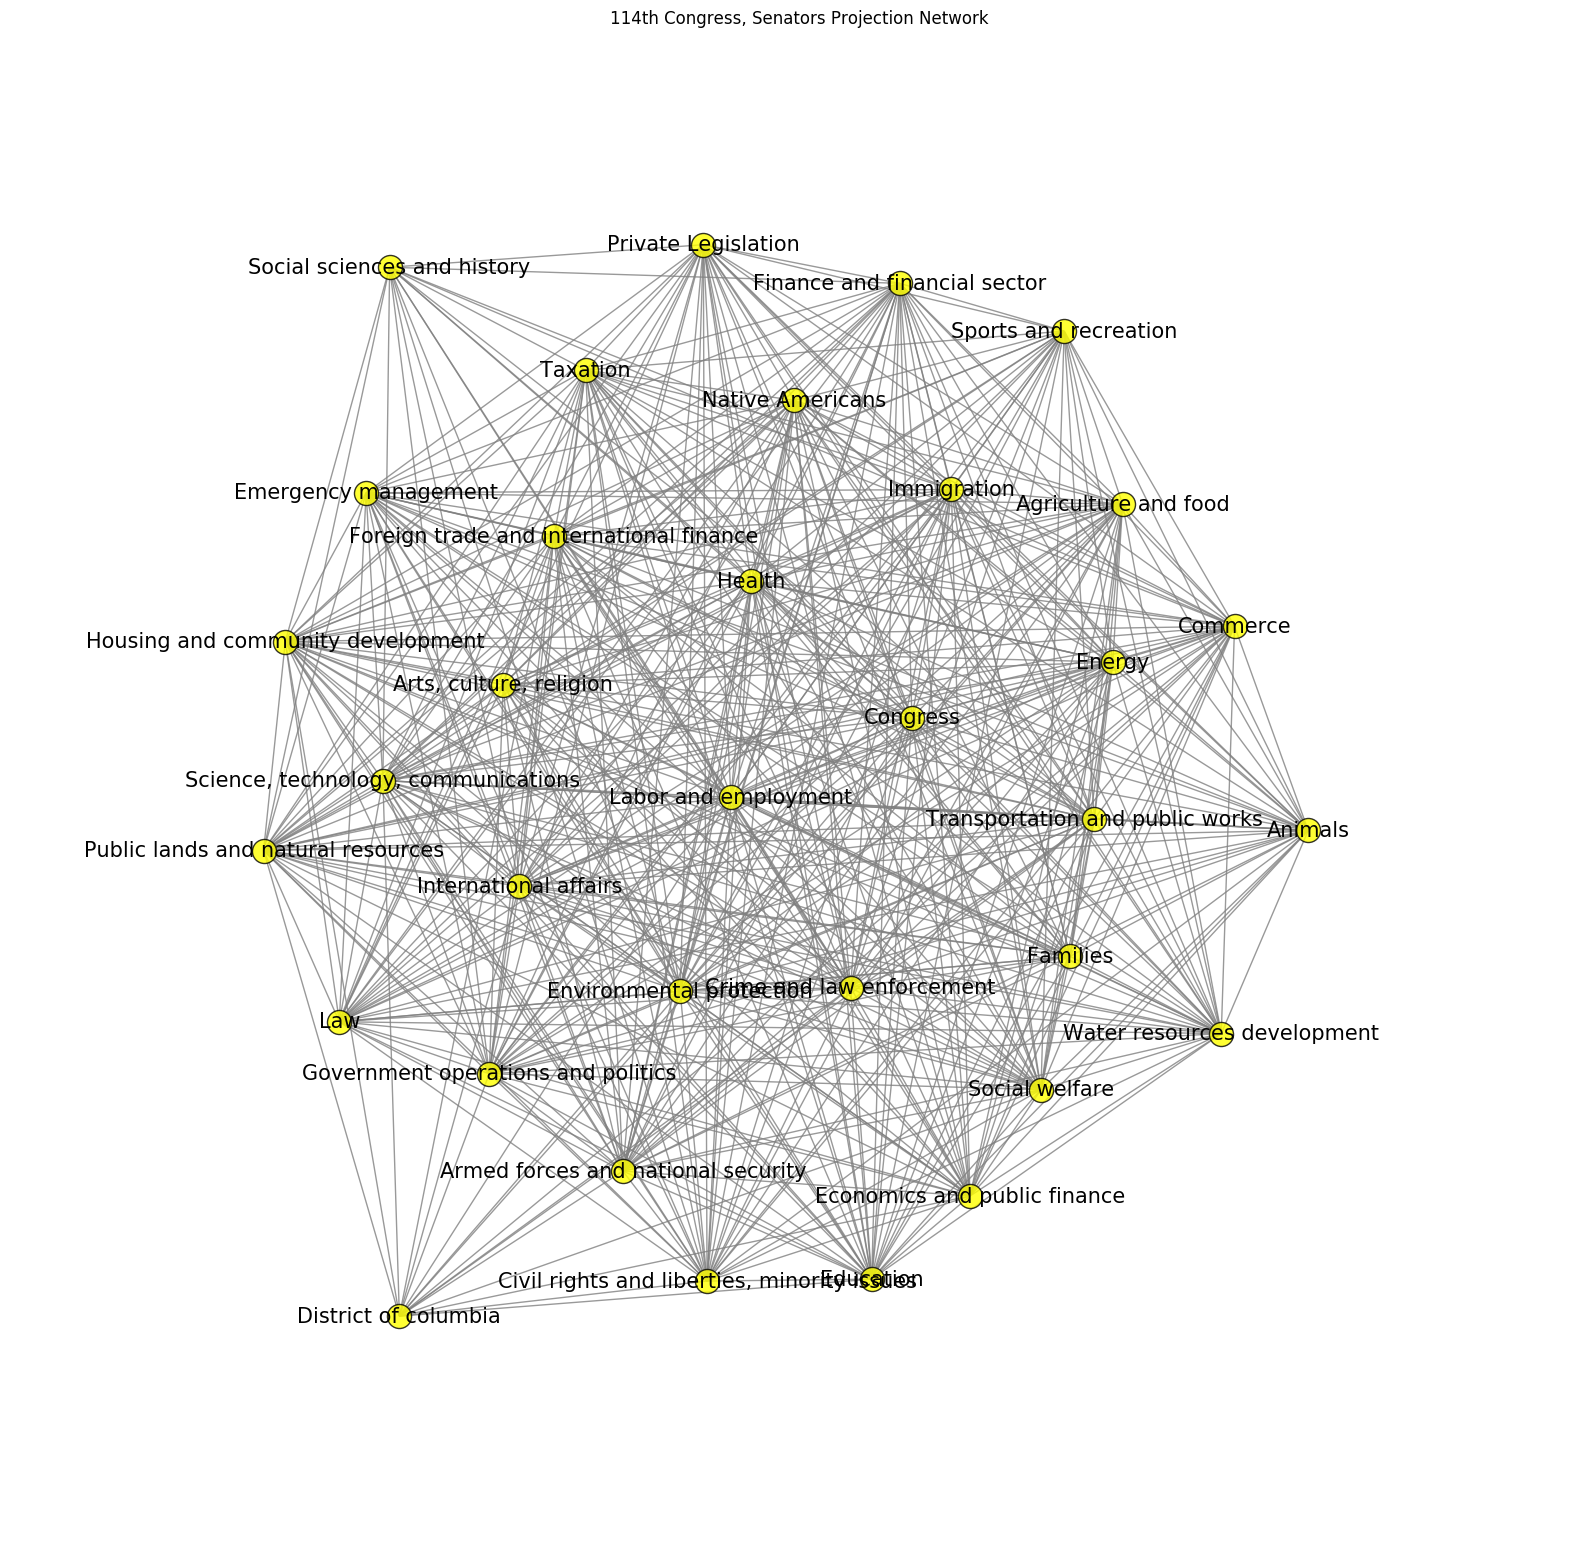

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

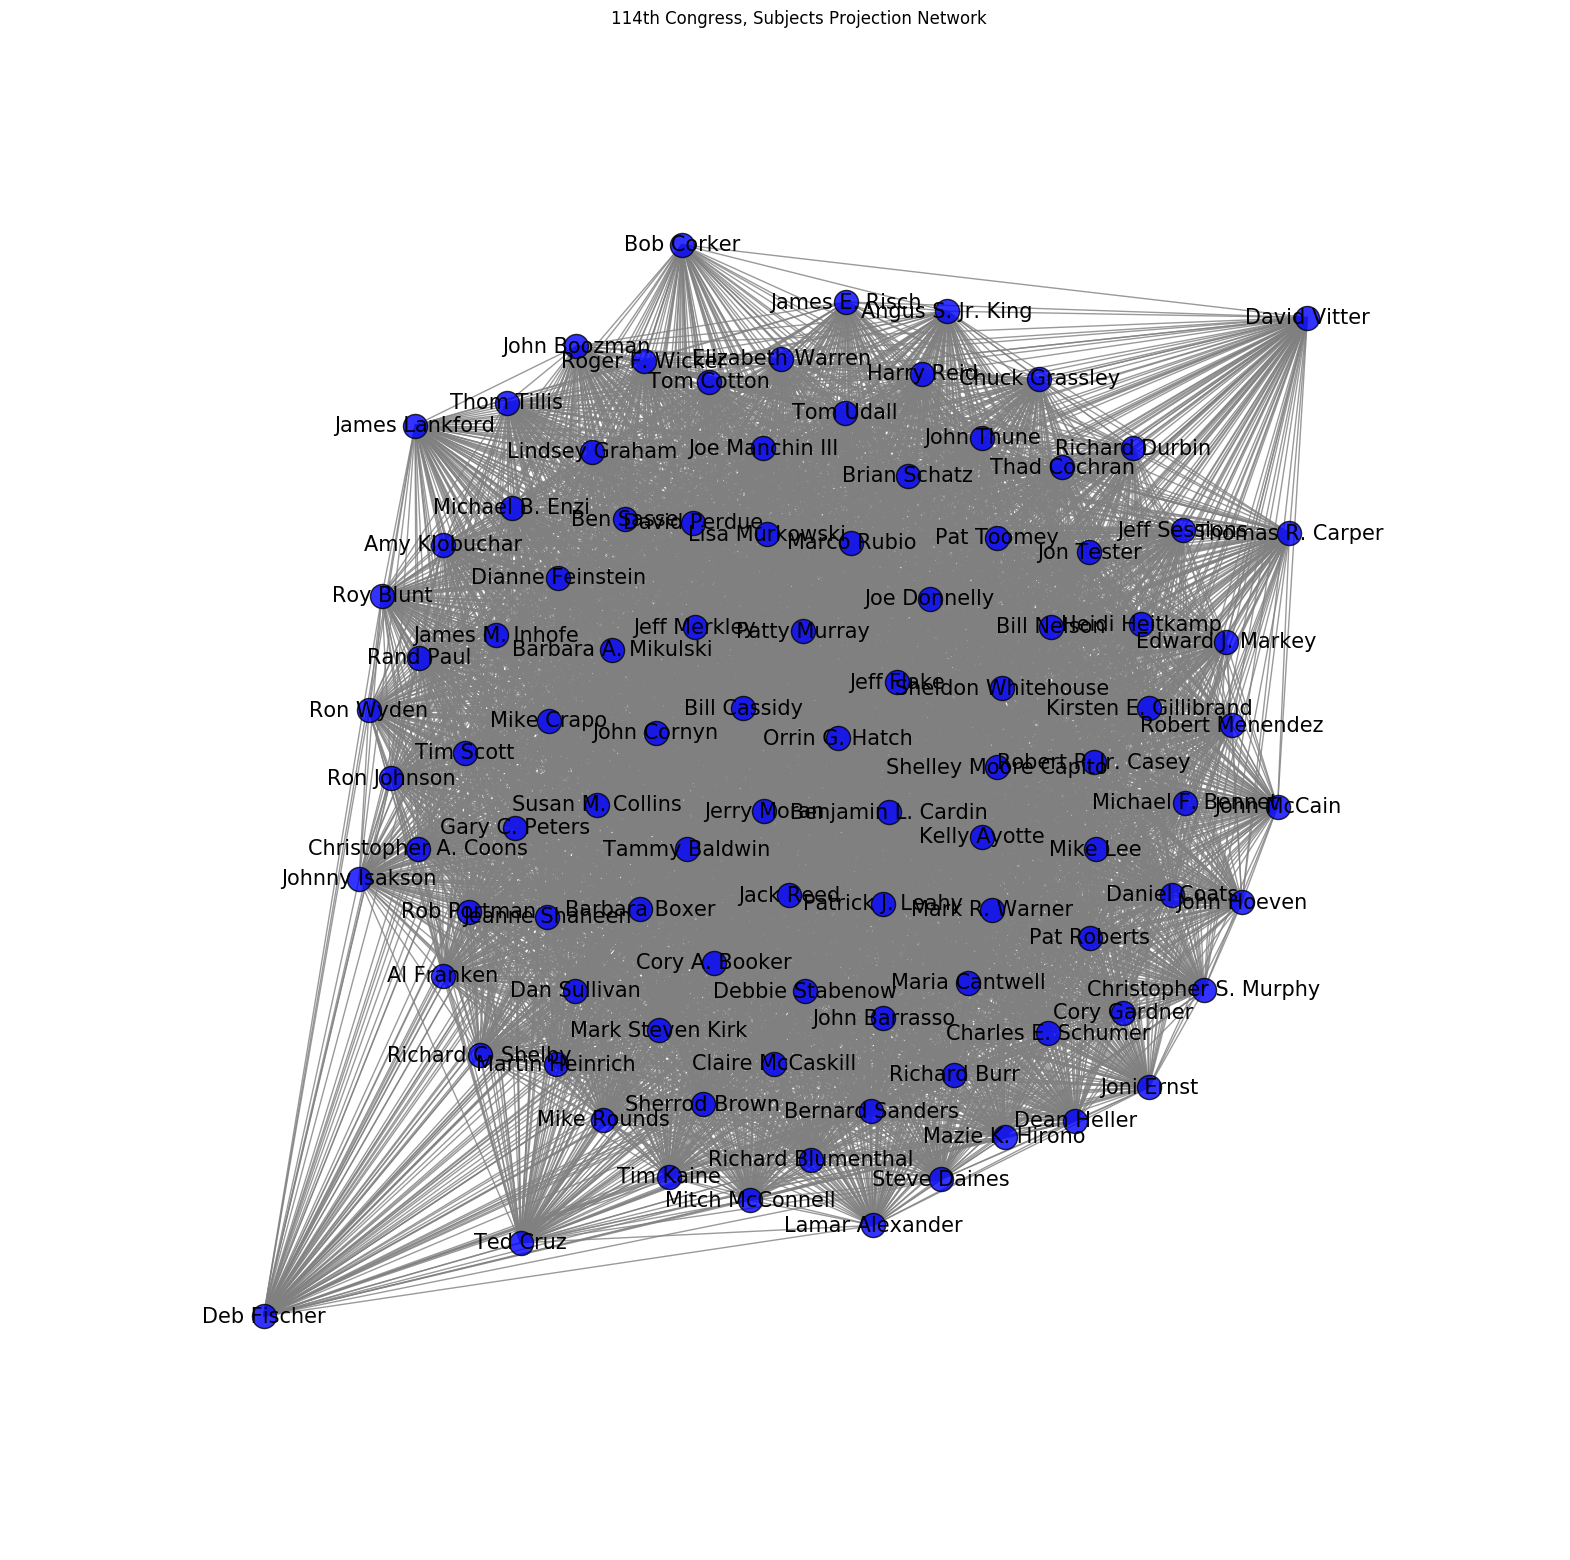

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
71                                Gary C. Peters    0.467979
45                              Edward J. Markey    0.466050
132                                Amy Klobuchar    0.465132
31                                   Rob Portman    0.458394
130                             Mark Steven Kirk    0.457735
81                                  Patty Murray    0.449602
41                                 Tammy Baldwin    0.443799
14                                  Brian Schatz    0.443223
95                                Orrin G. Hatch    0.438549
66                                     Roy Blunt    0.433688
39                                 Barbara Boxer    0.429799
119                                  Dean Heller    0.428701
33                                     Ron Wyden    0.428436
100                                 Kelly Ayotte    0.427624
120                               Richard Durbin    0.424544
10                         Kirsten E. Gillibrand    0.424226
123                                  John Cornyn    0.423339
127                                 David Vitter    0.422189
96                                Jeanne Shaheen    0.421120
2                                Michael B. Enzi    0.416889
48                                  Bill Cassidy    0.415656
49                                  Cory Gardner    0.414451
16                                   Jerry Moran    0.406920
15                                Cory A. Booker    0.406413
36                                    John Thune    0.406024
82                               Bernard Sanders    0.404171
40                                   Marco Rubio    0.402996
124                        Christopher S. Murphy    0.402861
58                            Sheldon Whitehouse    0.398786
72                                    Jeff Flake    0.398304
..                                           ...         ...
22                                James Lankford    0.248444
69                                    Harry Reid    0.244810
44                                  David Perdue    0.236183
77                                  Thad Cochran    0.228641
125                 Economics and public finance    0.218295
43                                Social welfare    0.214168
54                                   Immigration    0.211763
47                                           Law    0.207037
19                          Agriculture and food    0.205080
115                               James E. Risch    0.201195
91       Foreign trade and international finance    0.200920
35                                   Mike Rounds    0.189306
86                                     Ben Sasse    0.185288
63                              Native Americans    0.174577
90                   Water resources development    0.169541
32             Housing and community development    0.167055
74                                   Thom Tillis    0.165161
92                             Richard C. Shelby    0.164930
79                                 Jeff Sessions    0.153204
84                                       Animals    0.148732
111                         Emergency management    0.145375
17   Civil rights and liberties, minority issues    0.126924
114                                     Congress    0.118515
52                                      Families    0.118401
89                                    Bob Corker    0.101726
110                          Private Legislation    0.082698
56                       Arts, culture, religion    0.053245
53                         Sports and recreation    0.042717
21                   Social sciences and history    0.032616
13                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                               node2  \
0             Animals                Labor and employment   
1             Animals                Labor and employment   
2             Animals                Labor and employment   
3             Animals                Labor and employment   
4             Animals           Crime and law enforcement   
5             Animals           Crime and law enforcement   
6             Animals           Crime and law enforcement   
7             Animals           Crime and law enforcement   
8             Animals           Crime and law enforcement   
9             Animals           Crime and law enforcement   
10            Animals           Crime and law enforcement   
11            Animals           Crime and law enforcement   
12            Animals           Crime and law enforcement   
13            Animals           Crime and law enforcement   
14            Animals           Crime and law enforcement   
15            Animals  Public lands and natural resources   
16            Animals  Public lands and natural resources   
17            Animals                           Education   
18            Animals                           Education   
19            Animals                           Education   
20            Animals                           Education   
21            Animals                           Education   
22            Animals                           Education   
23            Animals                           Education   
24            Animals   Housing and community development   
25            Animals   Housing and community development   
26            Animals   Housing and community development   
27            Animals  Armed forces and national security   
28            Animals  Armed forces and national security   
29            Animals  Armed forces and national security   
...               ...                                 ...   
12902  Maria Cantwell                     Mitch McConnell   
12903  Maria Cantwell                    Thomas R. Carper   
12904  Maria Cantwell                    Thomas R. Carper   
12905  Maria Cantwell                       Sherrod Brown   
12906  Maria Cantwell                       Sherrod Brown   
12907  Maria Cantwell                   Richard C. Shelby   
12908  Maria Cantwell                      Orrin G. Hatch   
12909  Maria Cantwell                      Orrin G. Hatch   
12910  Maria Cantwell                      Orrin G. Hatch   
12911  Maria Cantwell                      Orrin G. Hatch   
12912  Maria Cantwell                          Pat Toomey   
12913  Maria Cantwell                  Richard Blumenthal   
12914  Maria Cantwell                  Richard Blumenthal   
12915  Maria Cantwell                  Richard Blumenthal   
12916  Maria Cantwell                        Thad Cochran   
12917  Maria Cantwell                    Patrick J. Leahy   
12918  Maria Cantwell                    Patrick J. Leahy   
12919  Maria Cantwell                     Martin Heinrich   
12920  Maria Cantwell                     Martin Heinrich   
12921  Maria Cantwell                     Martin Heinrich   
12922  Maria Cantwell                     Martin Heinrich   
12923  Maria Cantwell                        Steve Daines   
12924  Maria Cantwell                        Steve Daines   
12925  Maria Cantwell                      Mark R. Warner   
12926  Maria Cantwell                      Mark R. Warner   
12927  Maria Cantwell                      Mark R. Warner   
12928  Maria Cantwell                    Mark Steven Kirk   
12929  Maria Cantwell                    Mark Steven Kirk   
12930  Maria Cantwell                    Mark Steven Kirk   
12931  Maria Cantwell                    Mark Steven Kirk   

                                     node3  
0                          Lamar Alexander  
1                               Mike Crapo  
2                         Mark Steven Kirk  
3                           Maria Cantwell  
4       

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
131                                   Health       88
118                                 Taxation       82
12        Public lands and natural resources       73
103       Government operations and politics       72
42        Armed forces and national security       71
28           Transportation and public works       61
3                  Crime and law enforcement       61
26                                 Education       58
126                    International affairs       55
107             Finance and financial sector       55
106                 Environmental protection       54
51                                    Energy       51
87                                  Commerce       45
5                       Labor and employment       44
93       Science, technology, communications       42
125             Economics and public finance       36
43                            Social welfare       34
54                               Immigration       34
91   Foreign trade and international finance       32
63                          Native Americans       27
19                      Agriculture and food       27
47                                       Law       26
127                             David Vitter       23
90               Water resources development       22
32         Housing and community development       22
132                            Amy Klobuchar       21
72                                Jeff Flake       20
95                            Orrin G. Hatch       19
96                            Jeanne Shaheen       19
84                                   Animals       19
..                                       ...      ...
57                           Joe Manchin III       10
9                               Joe Donnelly       10
25                       Barbara A. Mikulski       10
61                                Al Franken       10
113                               Tom Cotton        9
97                                 Tim Kaine        9
64                           Martin Heinrich        9
18                                 Tim Scott        8
60                         Michael F. Bennet        8
30                            Lindsey Graham        8
6                            Lamar Alexander        8
34                              Daniel Coats        8
29                      Shelley Moore Capito        7
110                      Private Legislation        7
24                                Joni Ernst        7
22                            James Lankford        7
44                              David Perdue        7
77                              Thad Cochran        6
83                           Mitch McConnell        6
74                               Thom Tillis        5
35                               Mike Rounds        5
79                             Jeff Sessions        5
115                           James E. Risch        5
92                         Richard C. Shelby        4
86                                 Ben Sasse        4
56                   Arts, culture, religion        4
53                     Sports and recreation        3
89                                Bob Corker        3
21               Social sciences and history        1
13                      District of columbia        1

[134 rows x 2 columns]

On a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [21]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
47              Tom Udall       15
3                Ted Cruz       15
30          Tammy Baldwin       15
56       Susan M. Collins       15
29          Sherrod Brown       15
6               Roy Blunt       15
22              Ron Wyden       15
18            Ron Johnson       15
52    Robert P. Jr. Casey       15
38        Robert Menendez       15
21            Rob Portman       15
8          Richard Durbin       15
27           Richard Burr       15
75     Richard Blumenthal       15
20              Rand Paul       15
81       Patrick J. Leahy       15
48             Pat Toomey       15
68         Orrin G. Hatch       15
10               Mike Lee       15
5              Mike Crapo       15
0         Mazie K. Hirono       15
97       Mark Steven Kirk       15
95         Mark R. Warner       15
99         Maria Cantwell       15
64            Marco Rubio       15
33         Lisa Murkowski       15
7          Lindsey Graham       15
73           Kelly Ayotte       15
16             Joni Ernst       15
49             Jon Tester       15
..                    ...      ...
89           Steve Daines       13
40     Sheldon Whitehouse       13
13           Patty Murray       13
59            Pat Roberts       13
1         Michael B. Enzi       13
88        Martin Heinrich       13
2   Kirsten E. Gillibrand       13
67           John Boozman       13
54          John Barrasso       13
39        Joe Manchin III       13
14         James Lankford       13
50         Gary C. Peters       13
94         Chuck Grassley       13
92  Christopher S. Murphy       13
60        Bernard Sanders       13
70              Tim Kaine       11
12              Tim Scott        9
19   Shelley Moore Capito        9
63              Ben Sasse        9
98        Roger F. Wicker        8
57          Jeff Sessions        8
24            Mike Rounds        7
42      Michael F. Bennet        7
82            John Hoeven        7
77            Deb Fischer        7
66      Richard C. Shelby        6
4         Lamar Alexander        5
53            Thom Tillis        4
65             Bob Corker        2
84         James E. Risch        1

[100 rows x 2 columns]

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1             node2                 node3
0          Pat Roberts          Ted Cruz             Tom Udall
1          Pat Roberts          Ted Cruz           Thom Tillis
2          Pat Roberts          Ted Cruz             Tim Kaine
3          Pat Roberts          Ted Cruz            Tom Cotton
4          Pat Roberts          Ted Cruz             Tim Scott
5          Pat Roberts          Ted Cruz      Thomas R. Carper
6          Pat Roberts          Ted Cruz          Thad Cochran
7          Pat Roberts         Roy Blunt  Shelley Moore Capito
8          Pat Roberts         Roy Blunt         Tammy Baldwin
9          Pat Roberts         Roy Blunt    Sheldon Whitehouse
10         Pat Roberts         Roy Blunt             Tom Udall
11         Pat Roberts         Roy Blunt           Thom Tillis
12         Pat Roberts         Roy Blunt      Susan M. Collins
13         Pat Roberts         Roy Blunt             Tim Kaine
14         Pat Roberts         Roy Blunt            Tom Cotton
15         Pat Roberts         Roy Blunt              Ted Cruz
16         Pat Roberts         Roy Blunt             Tim Scott
17         Pat Roberts         Roy Blunt         Sherrod Brown
18         Pat Roberts         Roy Blunt      Thomas R. Carper
19         Pat Roberts         Roy Blunt          Thad Cochran
20         Pat Roberts         Roy Blunt          Steve Daines
21         Pat Roberts         Rand Paul             Roy Blunt
22         Pat Roberts         Rand Paul  Shelley Moore Capito
23         Pat Roberts         Rand Paul           Rob Portman
24         Pat Roberts         Rand Paul             Ron Wyden
25         Pat Roberts         Rand Paul          Richard Burr
26         Pat Roberts         Rand Paul         Tammy Baldwin
27         Pat Roberts         Rand Paul    Sheldon Whitehouse
28         Pat Roberts         Rand Paul             Tom Udall
29         Pat Roberts         Rand Paul           Thom Tillis
...                ...               ...                   ...
159012  Maria Cantwell  Mark Steven Kirk        Richard Durbin
159013  Maria Cantwell  Mark Steven Kirk           Ron Johnson
159014  Maria Cantwell  Mark Steven Kirk           Mike Rounds
159015  Maria Cantwell  Mark Steven Kirk         Sherrod Brown
159016  Maria Cantwell  Mark Steven Kirk       Robert Menendez
159017  Maria Cantwell  Mark Steven Kirk   Robert P. Jr. Casey
159018  Maria Cantwell  Mark Steven Kirk       Roger F. Wicker
159019  Maria Cantwell  Mark Steven Kirk      Thomas R. Carper
159020  Maria Cantwell  Mark Steven Kirk       Martin Heinrich
159021  Maria Cantwell  Mark Steven Kirk        Orrin G. Hatch
159022  Maria Cantwell  Mark Steven Kirk    Richard Blumenthal
159023  Maria Cantwell  Mark Steven Kirk          Thad Cochran
159024  Maria Cantwell  Mark Steven Kirk          Steve Daines
159025  Maria Cantwell   Roger F. Wicker             Roy Blunt
159026  Maria Cantwell   Roger F. Wicker  Shelley Moore Capito
159027  Maria Cantwell   Roger F. Wicker             Ron Wyden
159028  Maria Cantwell   Roger F. Wicker         Tammy Baldwin
159029  Maria Cantwell   Roger F. Wicker    Sheldon Whitehouse
159030  Maria Cantwell   Roger F. Wicker             Tom Udall
159031  Maria Cantwell   Roger F. Wicker           Thom Tillis
159032  Maria Cantwell   Roger F. Wicker      Susan M. Collins
159033  Maria Cantwell   Roger F. Wicker             Tim Kaine
159034  Maria Cantwell   Roger F. Wicker            Tom Cotton
159035  Maria Cantwell   Roger F. Wicker              Ted Cruz
159036  Maria Cantwell   Roger F. Wicker             Tim Scott
159037  Maria Cantwell   Roger F. Wicker           Ron Johnson
159038  Maria Cantwell   Roger F. Wicker         Sherrod Brown
159039  Maria Cantwell   Roger F. Wicker      Thomas R. Carper
159040  Maria Cantwell   Roger F. Wicker          Thad Cochran
159041  Maria Cantwell   Roger F. Wicker          Steve Daines

[159042 rows x 3 columns]

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 6, 8]    
16                        8                                             [3, 3, 2]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


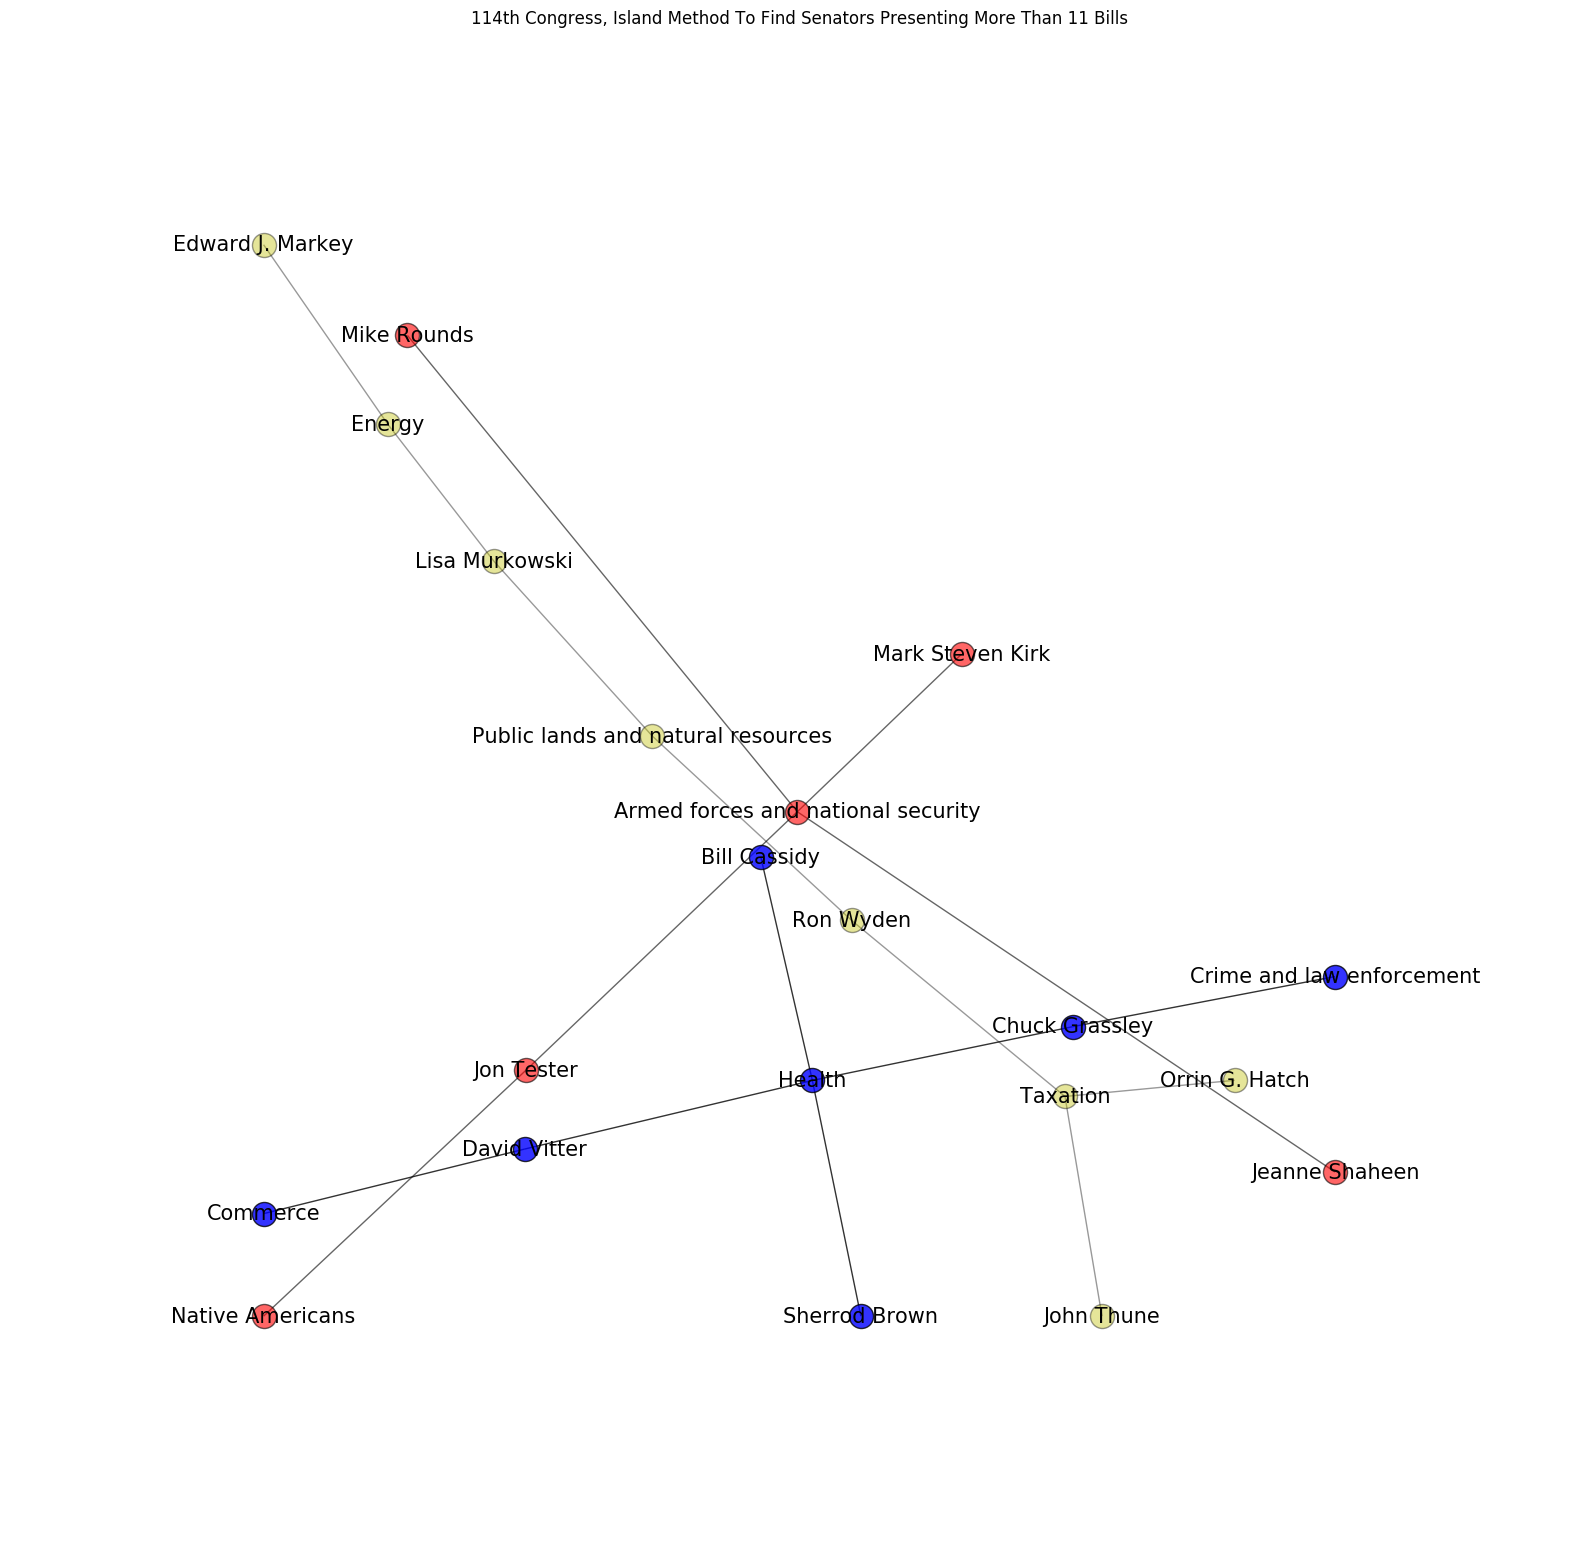

In [25]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


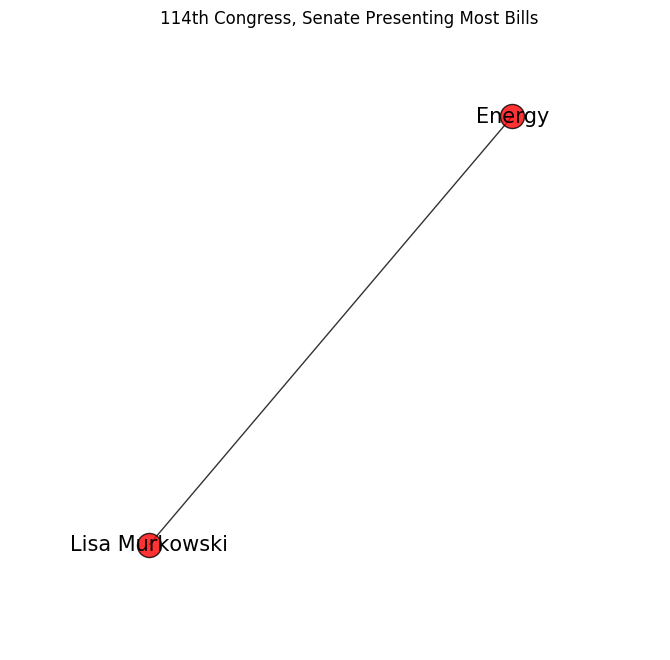

In [26]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()